In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import pickle as pkl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np 
import os
import numpy as np
import pickle as pkl
import jax.numpy as jnp
from tqdm import tqdm
from jax.tree_util import tree_map,tree_flatten,tree_flatten_with_path,keystr,tree_map_with_path
import matplotlib.pyplot as plt
from jax.numpy.linalg import matrix_norm,vector_norm

def unify_runs(path):
    stats = []
    for run in os.listdir(path):
        if not os.path.isfile(os.path.join(path,run,"stats.pkl")):
            continue
        with open(os.path.join(path,run,"stats.pkl"),"rb") as f:
            stats.append(pkl.load(f))
    
    if len(stats) == 0:
        return None
    if len(stats) == 1:
        return stats[0]
    
    return tree_map(lambda *x : jnp.stack(*x),*stats)

def get_max_acc(path):

    stats = unify_runs(path)

    if stats == None:
        return None

    test_acc = tree_flatten_with_path(stats["test_acc"])[0]
    train_acc = tree_flatten_with_path(stats["train_acc"])[0]

    keys, test_acc = [e[0] for e in test_acc],jnp.stack([e[1] for e in test_acc])
    train_acc = jnp.stack([e[1] for e in train_acc])

    argmax_test_accs = np.asarray([int(keystr(keys[i])[1:-1]) for i in jnp.argmax(test_acc,axis=0)])
    maximum_test_accs = np.asarray(test_acc[jnp.argmax(test_acc,axis=0),np.arange(test_acc.shape[-1])])
    train_accs = np.asarray(train_acc[jnp.argmax(test_acc,axis=0),np.arange(test_acc.shape[-1])])

    return argmax_test_accs,maximum_test_accs,train_accs


def compare_stats_settings(path):
    settings = {}
    if not os.path.isdir(path):
        return None,None
    
    for setting in os.listdir(path):

        settings[setting] = get_max_acc(os.path.join(path,setting))
    
    if settings == {}:
        return None,None
    
    highest_mean_acc_across_settings = max(settings,key=lambda x: np.mean(settings.get(x)[1]))
    return (np.mean(settings[highest_mean_acc_across_settings][1]),highest_mean_acc_across_settings, settings[highest_mean_acc_across_settings]),settings

def plot_xhyperparams_yacc(paths_and_hyperparams, label, ax=None):


    xy = [(h,get_max_acc(p)) for p,h in paths_and_hyperparams]
    xy = [(h,np.mean(acc[1])) for h,acc in xy if acc != None]
    x = [h for h,_ in xy]
    y = [acc for _,acc in xy]

    if ax == None:
        plt.plot(x,y,label=label)
    else:
        ax.plot(x,y,label=label)

def plot_stats(*paths):

    fig,axs = plt.subplots(nrows=1,ncols=len(paths))
    fig.set_size_inches(len(paths)*4,6)
    if len(paths) == 1:
        axs = [axs]
    for path,ax in zip(paths,axs):

        if not os.path.isfile(os.path.join(path,"stats.pkl")):
            continue

        with open(os.path.join(path,"stats.pkl"),"rb") as f:
            stats = pkl.load(f)

        train_acc = tree_flatten_with_path(stats["train_acc"])[0]
        test_acc = tree_flatten_with_path(stats["test_acc"])[0]

        train_x, train_y = np.asarray([keystr(e[0])[1:-1] for e in train_acc]),jnp.mean(jnp.stack([e[1] for e in train_acc]),axis=-1)
        test_x, test_y =np.asarray([keystr(e[0])[1:-1] for e in test_acc]),jnp.mean(jnp.stack([e[1] for e in test_acc]),axis=-1)

        ax.plot(train_x,train_y, label="train acc",c="blue")
        ax.plot(test_x,test_y, label="test acc",c="green")
        ax.plot(test_x,train_y-test_y, label="dif",c="red")
        ax.set_ylim(0.0,1.0)
        ax.legend()
        #ax.fill_between(x, y-error, y+error,alpha=0.3)
        #argmax = np.argmax(y)
        #max = np.max(y)
        #ax.plot([x[0],x[-1]],[max,max],c="red")
        #ax.plot([x[argmax],x[argmax]],[0,1],c="red")
        #ax.set_yticks((0,np.max(y),1))
        #ax.legend()


In [5]:
exps = ["./exps_adam/standard","./exps_adam/wd","./exps_adamw/wd","./exps_adam/norm", "./exps_adam/norm_layerwise_stepscale",
        "./exps_adam/center_norm","./exps_adam/center_norm_uncenter","./exps_adam/center_std_uncenter","./exps_adam/global_center_std_uncenter","./exps_adam/reverse_center_norm","./exps_sgdm/reverse_center_norm_uncenter",]
for exp in exps:
    print("{0}: {1}".format(exp,compare_stats_settings(exp)[0]))

./exps_adam/standard: (0.79946667, '0.00025', (array([171102, 171102, 168900]), array([0.8002001 , 0.8022    , 0.79600006], dtype=float32), array([0.99977994, 0.9993001 , 0.9981202 ], dtype=float32)))
./exps_adam/wd: (0.80576664, '0.00015000000000000001', (array([139169, 168900, 130917]), array([0.8084    , 0.80250007, 0.8064    ], dtype=float32), array([0.99744004, 0.9958    , 0.99690014], dtype=float32)))
b16_exps_adam/wd: None
./exps_adamw/wd: (0.8015334, '0.0001', (array([183888, 168900, 198920]), array([0.7981    , 0.80250007, 0.804     ], dtype=float32), array([0.9990402, 0.9994801, 0.9997801], dtype=float32)))
./exps_adam/norm: (0.8336334, '0.9_10', (array([183888, 183888, 170716]), array([0.8337001 , 0.8339001 , 0.83330005], dtype=float32), array([0.99477994, 0.99368   , 0.98999995], dtype=float32)))
./exps_adam/norm_layerwise_stepscale: (0.8330333, '0.8_100', (array([183888, 170688, 159184]), array([0.8338    , 0.83610004, 0.82919997], dtype=float32), array([0.98994   , 0.9926

In [5]:
exps = ["./exps_sgdm/standard","./exps_sgdm/wd" ,"./exps_sgdm/wd_slim","./exps_adam/norm","./exps_sgdm/norm_slim", "./exps_sgdm/norm_layerwise_stepscale",
        "./exps_sgdm/center_norm","./exps_sgdm/center_norm_uncenter","./exps_sgdm/center_std_uncenter","./exps_sgdm/global_center_std_uncenter","./exps_sgdm/reverse_center_norm","./exps_sgdm/reverse_center_norm_uncenter",]
for exp in exps:
    print("{0}: {1}".format(exp,compare_stats_settings(exp)[0]))

./exps_sgdm/standard: (0.8039334, '0.1', (array([198920,  58399, 159184]), array([0.8047001, 0.8029   , 0.8042001], dtype=float32), array([1.     , 0.99998, 1.     ], dtype=float32)))
./exps_sgdm/wd: (0.81310004, '0.00025', (array([25733, 25733, 56099]), array([0.8133001 , 0.8115    , 0.81450003], dtype=float32), array([1., 1., 1.], dtype=float32)))
./exps_sgdm/wd_slim: (0.7296667, '0.0025', (array([110881, 164628, 118674]), array([0.72540015, 0.73210007, 0.7315    ], dtype=float32), array([0.87136006, 0.8908801 , 0.88613987], dtype=float32)))
./exps_adam/norm: (0.8336334, '0.9_10', (array([183888, 183888, 170716]), array([0.8337001 , 0.8339001 , 0.83330005], dtype=float32), array([0.99477994, 0.99368   , 0.98999995], dtype=float32)))
./exps_sgdm/norm_slim: (0.72060007, '1.1_1', (array([183888,  76719, 150105]), array([0.7184, 0.7202, 0.7232], dtype=float32), array([0.88601995, 0.86372006, 0.88672   ], dtype=float32)))
./exps_sgdm/norm_layerwise_stepscale: (0.82526666, '0.7_1', (array(

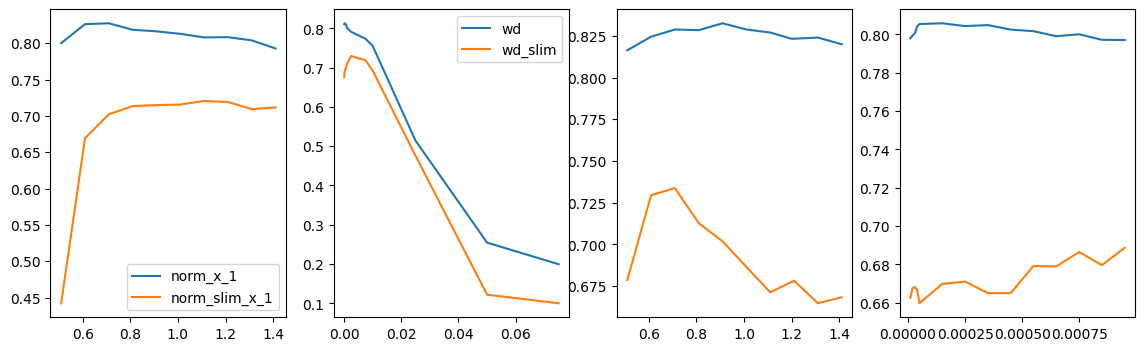

In [3]:
fig,axs = plt.subplots(ncols=4)
fig.set_size_inches((14,4))

plot_xhyperparams_yacc(sorted([(os.path.join("./exps_sgdm/norm",setting),float(setting)) for setting in os.listdir("./exps_sgdm/norm") if setting.endswith("1")]
                              ,key=lambda x : x[1]),"norm_x_1",axs[0])
plot_xhyperparams_yacc(sorted([(os.path.join("./exps_sgdm/norm_slim",setting),float(setting)) for setting in os.listdir("./exps_sgdm/norm_slim") if setting.endswith("1")]
                              ,key=lambda x : x[1]),"norm_slim_x_1",axs[0])

plot_xhyperparams_yacc(sorted([(os.path.join("./exps_sgdm/wd",setting),float(setting)) for setting in os.listdir("./exps_sgdm/wd") if float(setting)>=0.00001]
                              ,key=lambda x : x[1]),"wd",axs[1])
plot_xhyperparams_yacc(sorted([(os.path.join("./exps_sgdm/wd_slim",setting),float(setting)) for setting in os.listdir("./exps_sgdm/wd_slim")if float(setting)>=0.00001]
                              ,key=lambda x : x[1]),"wd_slim",axs[1])

plot_xhyperparams_yacc(sorted([(os.path.join("./exps_adam/norm",setting),float(setting)) for setting in os.listdir("./exps_adam/norm") if setting.endswith("1")]
                              ,key=lambda x : x[1]),"norm_x_1",axs[2])
plot_xhyperparams_yacc(sorted([(os.path.join("./exps_adam/norm_slim",setting),float(setting)) for setting in os.listdir("./exps_adam/norm_slim") if setting.endswith("1")]
                              ,key=lambda x : x[1]),"norm_slim_x_1",axs[2])

plot_xhyperparams_yacc(sorted([(os.path.join("./exps_adam/wd",setting),float(setting)) for setting in os.listdir("./exps_adam/wd") if float(setting)>=0.00001]
                              ,key=lambda x : x[1]),"wd",axs[3])
plot_xhyperparams_yacc(sorted([(os.path.join("./exps_adam/wd_slim",setting),float(setting)) for setting in os.listdir("./exps_adam/wd_slim")if float(setting)>=0.00001]
                              ,key=lambda x : x[1]),"wd_slim",axs[3])

axs[0].legend()
axs[1].legend()


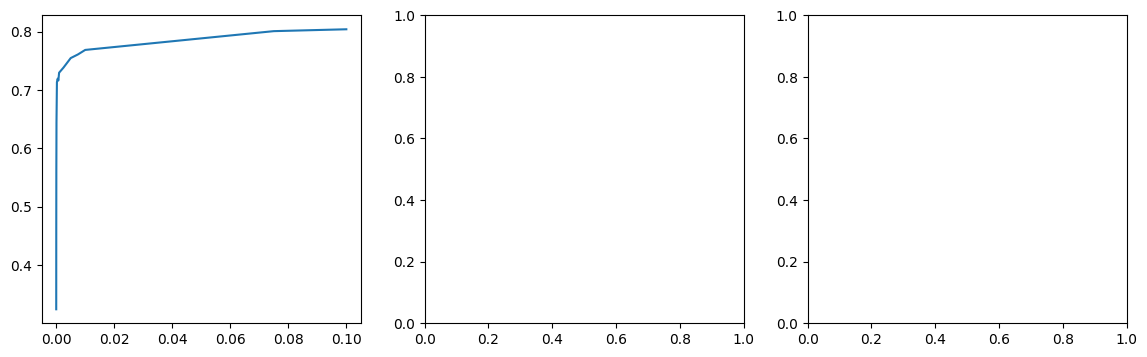

In [2]:
fig,axs = plt.subplots(ncols=3)
fig.set_size_inches((14,4))

plot_xhyperparams_yacc(sorted([(os.path.join("./exps_sgdm/standard",setting),float(setting)) for setting in os.listdir("./exps_sgdm/standard")]
                              ,key=lambda x : x[1]),"standard",axs[0])